<a href="https://colab.research.google.com/github/tkazusa/keras_practice/blob/master/SuperResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Super Resolution

In [0]:
from google.colab import drive
drive.mount('/content/drive')


import os
import glob
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Input, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator

### 低解像度の画像の生成

In [0]:
def drop_resolution(x, scale=3.0):
    size = (x.shape[0], x.shape[1])
    small_size = (int(size[0]/scale), int(size[1]/scale))
    img = array_to_img(x)
    small_img = img.resize(small_size, 3)
    return img_to_array(small_img.resize(img.size, 3))
  
  def data_generator(data_dir, mode, scale=2.0, target_size=(200, 200), batch_size=32, shuffle=True):
    for imgs in ImageDataGenerator().flow_from_directory(
        directory=data_dir,
        classes=[mode],
        class_mode=None,
        color_mode='rgb',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=shuffle):
        x = np.array([drop_resolution(img, scale) for img in imgs])
        yield x/255., imgs/255.
        
        
DATA_DIR = 'data/chap10/'
N_TRAIN_DATA = 1000
N_TEST_DATA = 100
BATCH_SIZE = 32

train_data_generator = data_generator(DATA_DIR, 'train', batch_size=BATCH_SIZE)
test_x, test_y = next(
    data_generator(
        DATA_DIR,
        'test',
        batch_size=N_TEST_DATA,
        shuffle=False))

### SRCNNの定義

In [0]:
def build_SRCNN():
  model = Sequential()
  model.add(Conv2D(filters=64, kernel_size=9, padding='same', activation='relu', input_shape=(None, None, 3)))
  model.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=3, kernel_size=5, padding='same'))
  return model

model = build_SRCNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 64)    15616     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 3)     2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


### PSNRをmetricsに指定して学習を実行

In [0]:
def psnr(y_true, y_pred):
    return -10*K.log(
        K.mean(K.flatten((y_true - y_pred))**2)
    )/np.log(10)

model.compile(
    loss='mean_squared_error', 
    optimizer='adam', 
    metrics=[psnr]
)

model.fit_generator(
    train_data_generator,
    validation_data=(test_x, test_y),
    steps_per_epoch=N_TRAIN_DATA//BATCH_SIZE,
    epochs=50
)

# テストデータに対して適用
pred = model.predict(test_x)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/50
Found 1000 images belonging to 1 classes.
31/31 [==============================]31/31 [==============================] - 12s 389ms/step - loss: 0.0357 - psnr: 15.8332 - val_loss: 0.0146 - val_psnr: 18.3975

Epoch 2/50
31/31 [==============================]31/31 [==============================] - 7s 225ms/step - loss: 0.0115 - psnr: 19.4376 - val_loss: 0.0109 - val_psnr: 19.6694

Epoch 3/50
31/31 [==============================]31/31 [==============================] - 7s 216ms/step - loss: 0.0084 - psnr: 20.8039 - val_loss: 0.0084 - val_psnr: 20.7938

Epoch 4/50
31/31 [==============================]31/31 [==============================] - 7s 214ms/step - loss: 0.0069 - psnr: 21.6372 - val_loss: 0.0069 - val_psnr: 21.7020

Epoch 5/50
31/31 [==============================]31/31 [==============================] - 7s 215ms/step - loss: 0.0063 - psnr: 22.0711 - val_loss: 0.0064 - val_psnr: 22.0146

Epoch 6/5

### 正解データ

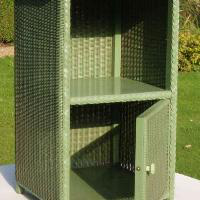

In [0]:
array_to_img(test_y[0])


### 入力データ

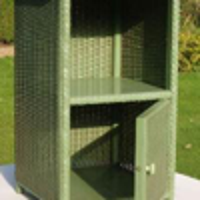

In [0]:
array_to_img(test_x[0])

#### 予測結果

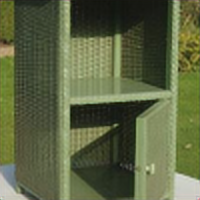

In [0]:
array_to_img(pred[0])

**リスト10.7:モデルの構築**

In [0]:
def build_CAE_SkipConnection():
  # 入力は任意のサイズで、3チャンネルの画像
  inputs = Input((None, None, 3), dtype='float')

  # Endoder
  conv1 = Conv2D(64, 3, padding='same')(inputs)
  conv1 = Conv2D(64, 3, padding='same')(conv1)

  conv2 = Conv2D(64, 3, strides=2, padding='same')(conv1)
  conv2 = Conv2D(64, 3, padding='same')(conv2)

  conv3 = Conv2D(64, 3, strides=2, padding='same')(conv2)
  conv3 = Conv2D(64, 3, padding='same')(conv3)

  # Decoder
  deconv3 = Conv2DTranspose(64, 3, padding='same')(conv3)
  deconv3 = Conv2DTranspose(64, 3, strides=2, padding='same')(deconv3)

  # Add()レイヤーを使ってスキップコネクションを表現
  merge2 = Add()([deconv3, conv2])
  deconv2 = Conv2DTranspose(64, 3, padding='same')(merge2)
  deconv2 = Conv2DTranspose(64, 3, strides=2, padding='same')(deconv2)

  merge1 = Add()([deconv2, conv1])
  deconv1 = Conv2DTranspose(64, 3, padding='same')(merge1)
  deconv1 = Conv2DTranspose(3, 3, padding='same')(deconv1)

  output = Add()([deconv1, inputs])

  model = Model(inputs, output)
  return model

model = build_build_CAE_SkipConnection()
model.summary()

### PSNRをmetricsに指定して学習を実行

In [0]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam', 
    metrics=[psnr]
)

model.fit_generator(
    train_data_generator,
    validation_data=(test_x, test_y),
    steps_per_epoch=N_TRAIN_DATA//BATCH_SIZE,
    epochs=50
)

# テストデータに対して適用
pred = model.predict(test_x)

Epoch 1/50
31/31 [==============================]31/31 [==============================] - 31s 1s/step - loss: 0.0284 - psnr: 19.7318 - val_loss: 0.0051 - val_psnr: 23.0477

Epoch 2/50
31/31 [==============================]31/31 [==============================] - 27s 865ms/step - loss: 0.0040 - psnr: 23.9794 - val_loss: 0.0042 - val_psnr: 23.8701

Epoch 3/50
31/31 [==============================]31/31 [==============================] - 27s 879ms/step - loss: 0.0038 - psnr: 24.2852 - val_loss: 0.0041 - val_psnr: 24.0751

Epoch 4/50
31/31 [==============================]31/31 [==============================] - 27s 867ms/step - loss: 0.0038 - psnr: 24.2812 - val_loss: 0.0040 - val_psnr: 24.1832

Epoch 5/50
31/31 [==============================]31/31 [==============================] - 27s 868ms/step - loss: 0.0036 - psnr: 24.4721 - val_loss: 0.0039 - val_psnr: 24.2462

Epoch 6/50
31/31 [==============================]31/31 [==============================] - 27s 867ms/step - loss: 0.0037 - p

### 正解データ

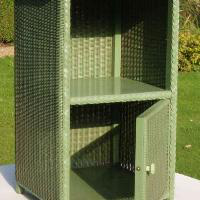

In [0]:
array_to_img(test_y[0])

### 入力データ

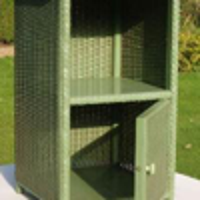

In [0]:
array_to_img(test_x[0])

### 予測結果

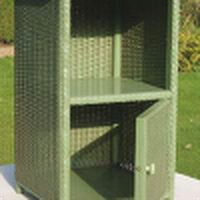

In [0]:
array_to_img(pred[0])